In [2]:
!nvidia-smi

Wed Jan 22 11:21:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   28C    P8    13W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   27C    P8     4W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [2]:
neg_path = load_path('train', 'n', 'neg', data = 'sm_v2')
redspot_path = load_path('train', 'h', 'redspot', data = 'sm_v2')
angio_path = load_path('train', 'h', 'angio', data = 'sm_v2')
active_path = load_path('train', 'h', 'active', data = 'sm_v2')
ero_path = load_path('train', 'd', 'ero', data = 'sm_v2')
ulcer_path = load_path('train', 'd', 'ulcer', data = 'sm_v2')
str_path = load_path('train', 'd', 'str', data = 'sm_v2')

print("negative:",neg_path.shape)
print("red spot:",redspot_path.shape)
print("angioectasia:",angio_path.shape)
print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (49960,)
red spot: (4448,)
angioectasia: (144,)
active_bleeding: (3424,)
erosion: (5896,)
ulcer: (5856,)
stricture: (824,)


In [3]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
angio_train_path, angio_valid_path = train_valid_split(angio_path)
active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (42466,) (7494,)
red spot: (3781,) (667,)
angioectasia: (122,) (22,)
active bleeding: (2910,) (514,)
erosion: (5012,) (884,)
ulcer: (4978,) (878,)
stricture: (700,) (124,)


# Model

In [4]:
input_h = 512
input_w = 512
input_ch = 3

k1_ch = 16
# 256 256 16

k2_ch = 16
# 128 128 16

k3_ch = 16
# 64 64 16

k4_ch = 32
# 32 32 32

k5_ch = 32
# 16 16 32

k6_ch = 32
# 8 8 32

k7_ch = 64
# 4 4 64

n_hidden1 = 100
n_hidden2 = 50
n_output = 2

In [5]:
class CE_cnn:
    def __init__(self, k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output):
        self.k1_ch = k1_ch
        self.k2_ch = k2_ch
        self.k3_ch = k3_ch
        self.k4_ch = k4_ch
        self.k5_ch = k5_ch
        self.k6_ch = k6_ch
        self.k7_ch = k7_ch
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.n_output = n_output
    def conv_block(self, x, k_channel, maxp_name = 'maxp'):
        conv1 = tf.layers.conv2d(inputs = x, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs = conv1, 
                                 filters = k_channel, 
                                 kernel_size = [3, 3], 
                                 padding = "SAME",
                                 activation= tf.nn.relu)
        maxp = tf.layers.max_pooling2d(inputs = conv2, 
                                       pool_size = [2, 2], 
                                       strides = 2,
                                       name = maxp_name)
        return maxp

    def fc2_layers(self, x, n_hidden1, n_hidden2, n_output, score_name = 'score'):
        maxp_re = tf.layers.flatten(x)
        hidden1 = tf.layers.dense(inputs = maxp_re, 
                                  units = n_hidden1,
                                  activation = tf.nn.relu)
        hidden1 = tf.layers.dropout(hidden1, rate = 0.3, training = is_training) # Drouout
        hidden2 = tf.layers.dense(inputs = hidden1, 
                                  units = n_hidden2,
                                  activation = tf.nn.relu)
        hidden2 = tf.layers.dropout(hidden2, rate = 0.3, training = is_training) # Drouout
        score = tf.layers.dense(inputs = hidden2, units = n_output, name = score_name)
        return score

    def inf(self, x):
        conv1 = self.conv_block(x, self.k1_ch, 'maxp1')
        conv2 = self.conv_block(conv1, self.k2_ch, 'maxp2')
        conv3 = self.conv_block(conv2, self.k3_ch, 'maxp3')
        conv4 = self.conv_block(conv3, self.k4_ch, 'maxp4')
        conv5 = self.conv_block(conv4, self.k5_ch, 'maxp5')
        conv6 = self.conv_block(conv5, self.k6_ch, 'maxp6')
        conv7 = self.conv_block(conv6, self.k7_ch, 'maxp7')

        score = self.fc2_layers(conv7, self.n_hidden1, self.n_hidden2, self.n_output, 'score')

        return score

In [6]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
LR = tf.placeholder(tf.float32)
is_training = tf.placeholder(tf.bool, name = 'is_training')

model = CE_cnn(k1_ch, k2_ch, k3_ch, k4_ch, k5_ch, k6_ch, k7_ch, n_hidden1, n_hidden2, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0111 12:32:38.562780 140315485054720 deprecation.py:323] From <ipython-input-5-249d499180cf>:18: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0111 12:32:38.569215 140315485054720 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0111 12:32:38.783269 140315485054720 deprecation.py:323] From <ipython-input-5-249d499180cf>:27: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0111 12:32:39.082390 140315485054720 deprecation.py:323] F

# Training

## equal batch-size by class and damaped exp LR

damped_exp_LR(15000) <br>
t_batch = 32 <br>
v_batch = 128 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [7]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

a_train_path = np.hstack([h_train_path, d_train_path])
a_valid_path = np.hstack([h_valid_path, d_valid_path])

a_train_path = shuffle(a_train_path, None)
a_valid_path = shuffle(a_valid_path, None)

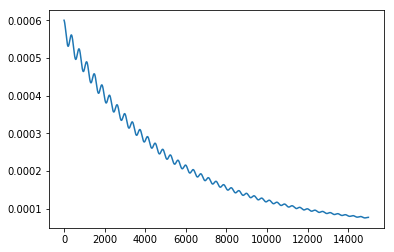

In [8]:
D_lr = damped_exp_LR(15000)

plt.plot(D_lr)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 70.00 %    || 61.00 %    || 0.60168219 || 0.64256066
--------------------------------------------------------------


W0111 12:35:45.676095 140315485054720 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*200] || 70.00 %    || 72.00 %    || 0.57397425 || 0.58911061
--------------------------------------------------------------
[*300] || 73.00 %    || 70.00 %    || 0.51813394 || 0.52957320
--------------------------------------------------------------
[*400] || 72.00 %    || 77.00 %    || 0.57423270 || 0.50878042
--------------------------------------------------------------
[*500] || 80.00 %    || 79.00 %    || 0.46863994 || 0.44884440
--------------------------------------------------------------
[*600] || 83.00 %    || 72.00 %    || 0.40525329 || 0.61768937
--------------------------------------------------------------
[*700] || 76.00 %    || 72.00 %    || 0.48054296 || 0.58494711
--------------------------------------------------------------
[*800] || 77.00 %    || 78.00 %    || 0.46976796 || 0.45426658
--------------------------------------------------------------
[*900] || 77.00 %    || 81.00 %    || 0.46577874 || 0.41678345
-------------------------------------------------------

[6800] || 95.00 %    || 95.00 %    || 0.22797218 || 0.16812646
--------------------------------------------------------------
[6900] || 99.00 %    || 95.00 %    || 0.02492772 || 0.11614022
--------------------------------------------------------------
[7000] || 95.00 %    || 94.00 %    || 0.09394798 || 0.09615738
--------------------------------------------------------------
[7100] || 98.00 %    || 99.00 %    || 0.04270739 || 0.04370468
--------------------------------------------------------------
[7200] || 97.00 %    || 97.00 %    || 0.04449214 || 0.09173273
--------------------------------------------------------------
[7300] || 97.00 %    || 99.00 %    || 0.09026285 || 0.03735463
--------------------------------------------------------------
[7400] || 99.00 %    || 95.00 %    || 0.05924622 || 0.14517693
--------------------------------------------------------------
[7500] || 96.00 %    || 96.00 %    || 0.07428551 || 0.15091726
-------------------------------------------------------

[13300] || 100.00 %    || 95.00 %    || 0.00732946 || 0.09185674
--------------------------------------------------------------
[13400] || 100.00 %    || 98.00 %    || 0.00779780 || 0.15743962
--------------------------------------------------------------
[13500] || 100.00 %    || 95.00 %    || 0.00298670 || 0.20073162
--------------------------------------------------------------
[13600] || 100.00 %    || 97.00 %    || 0.00060855 || 0.09766760
--------------------------------------------------------------
[13700] || 100.00 %    || 97.00 %    || 0.00107293 || 0.13108370
--------------------------------------------------------------
[13800] || 100.00 %    || 99.00 %    || 0.00039817 || 0.01452375
--------------------------------------------------------------
[13900] || 100.00 %    || 96.00 %    || 0.00183587 || 0.36208686
--------------------------------------------------------------
[14000] || 100.00 %    || 98.00 %    || 0.00266959 || 0.06022532
---------------------------------------

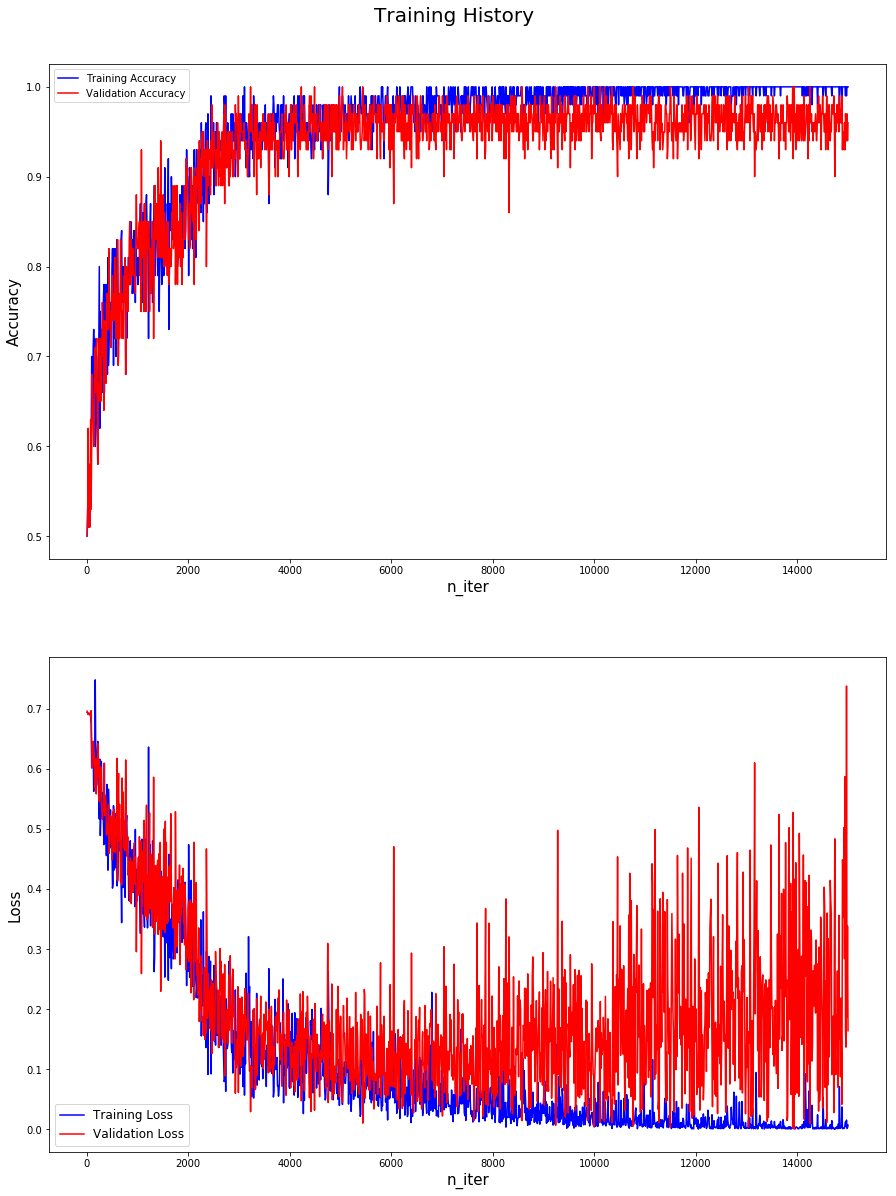

In [9]:
n_iter = 0
t_batch = 50
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 15000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and damaped exp LR and early stopping

damped_exp_LR(15000) <br>
t_batch = 32 <br>
v_batch = 128 <br>
cal_interval = 10 <br>
prt_interval = 100 <br>
early stopping = True <br>

In [13]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

a_train_path = np.hstack([h_train_path, d_train_path])
a_valid_path = np.hstack([h_valid_path, d_valid_path])

a_train_path = shuffle(a_train_path, None)
a_valid_path = shuffle(a_valid_path, None)

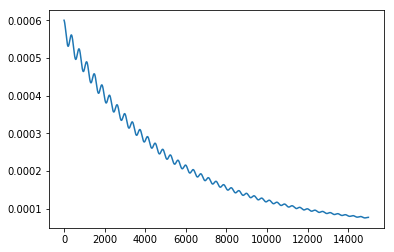

In [14]:
D_lr = damped_exp_LR(15000)

plt.plot(D_lr)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 69.00 %    || 67.00 %    || 0.57166409 || 0.59266162
--------------------------------------------------------------
[*200] || 85.00 %    || 83.00 %    || 0.32869750 || 0.35211328
--------------------------------------------------------------
[*300] || 92.00 %    || 81.00 %    || 0.22680768 || 0.40411326
--------------------------------------------------------------
[*400] || 86.00 %    || 88.00 %    || 0.34262031 || 0.35426947
--------------------------------------------------------------
[*500] || 86.00 %    || 92.00 %    || 0.26219523 || 0.15622158
--------------------------------------------------------------
[*600] || 92.00 %    || 93.00 %    || 0.19110563 || 0.18279825
--------------------------------------------------------------
[*700] || 95.00 %    || 93.00 %    || 0.18550417 || 0.15652022
--------------------------------------------------------------
[*800] || 96.00 %    || 88.00 %    || 0.08777958 || 0.2

[6500] || 99.00 %    || 97.00 %    || 0.02980078 || 0.14967662
--------------------------------------------------------------
[6600] || 97.00 %    || 92.00 %    || 0.05720240 || 0.31326842
--------------------------------------------------------------
[6700] || 98.00 %    || 98.00 %    || 0.07045039 || 0.05809373
--------------------------------------------------------------
[6800] || 98.00 %    || 96.00 %    || 0.06139248 || 0.15644670
--------------------------------------------------------------
[6900] || 100.00 %    || 97.00 %    || 0.01407361 || 0.15180106
--------------------------------------------------------------
[7000] || 100.00 %    || 98.00 %    || 0.01130194 || 0.09043206
--------------------------------------------------------------
[7100] || 99.00 %    || 96.00 %    || 0.02800001 || 0.20704451
--------------------------------------------------------------
[7200] || 100.00 %    || 98.00 %    || 0.00750295 || 0.05799236
----------------------------------------------------

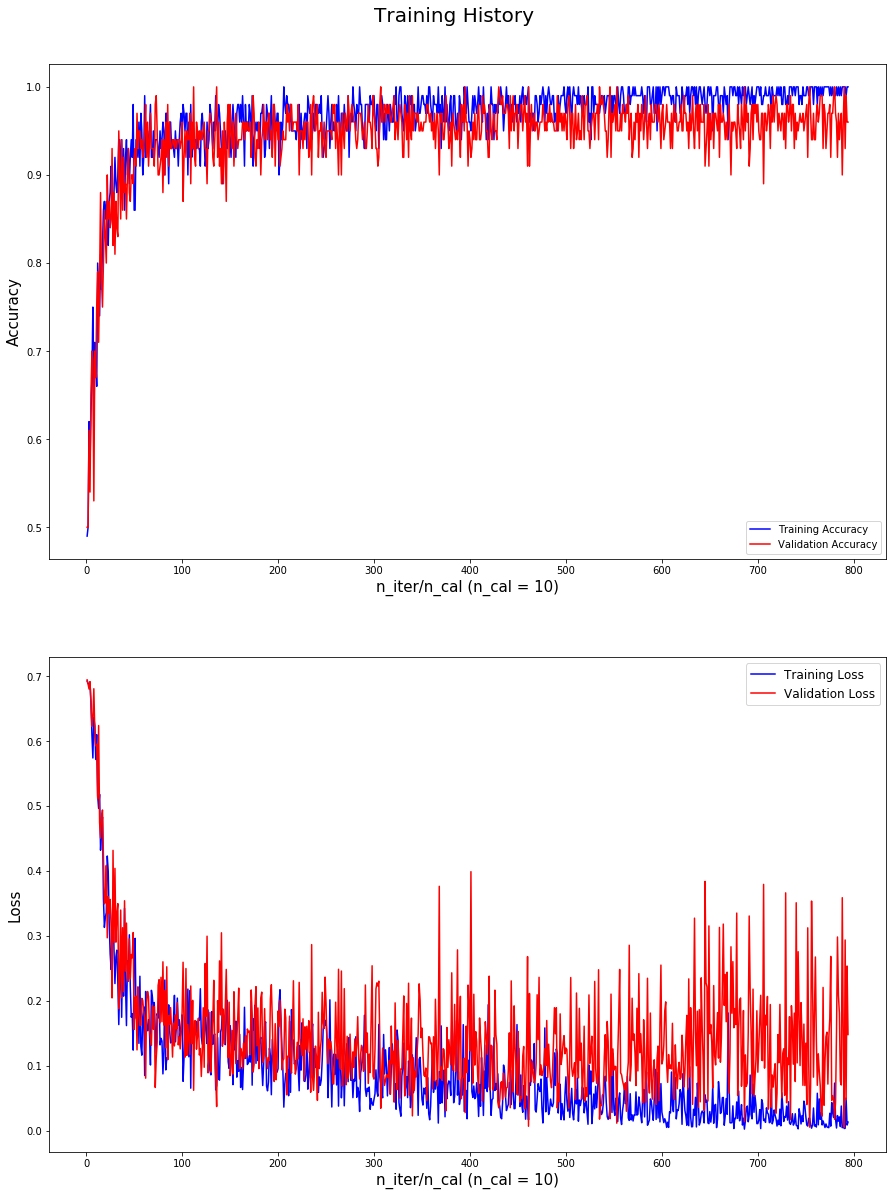

In [15]:
n_iter = 0
t_batch = 50
v_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
#         if n_iter == 20000:
#             break
        if n_iter > 5000:
            if np.max(accr_train) < 0.9:
                if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
                    hist.early_under(n_iter)
                    early_stopping = True
                    break
            if np.mean(accr_train[-50:]) >= 0.995:
                if (
                    np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
                    loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
                    ):
                    hist.early_over(n_iter)
                    early_stopping = True
                    break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and damaped exp LR

In [682]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

h_train_path = np.hstack([redspot_train_path, angio_train_path, active_train_path])
h_valid_path = np.hstack([redspot_valid_path, angio_valid_path, active_valid_path])

a_train_path = np.hstack([h_train_path, d_train_path])
a_valid_path = np.hstack([h_valid_path, d_valid_path])

a_train_path = shuffle(a_train_path, None)
a_valid_path = shuffle(a_valid_path, None)

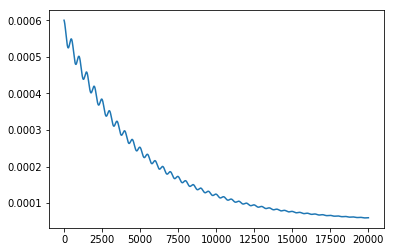

In [688]:
plt.plot(damped_exp_LR(20000))
D_lr = damped_exp_LR(20000)

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[*100] || 71.67 %    || 65.00 %    || 0.58637393 || 0.59753460
--------------------------------------------------------------
[*200] || 65.00 %    || 66.25 %    || 0.62378377 || 0.61114842
--------------------------------------------------------------
[*300] || 66.67 %    || 71.67 %    || 0.63479561 || 0.56925899
--------------------------------------------------------------
[*400] || 83.33 %    || 72.50 %    || 0.46755090 || 0.56469899
--------------------------------------------------------------
[*500] || 66.67 %    || 72.50 %    || 0.64471233 || 0.51562315
--------------------------------------------------------------
[*600] || 66.67 %    || 74.17 %    || 0.61485839 || 0.51933181
--------------------------------------------------------------
[*700] || 76.67 %    || 75.00 %    || 0.50157130 || 0.52922779
--------------------------------------------------------------
[*800] || 75.00 %    || 82.92 %    || 0.45805529 || 0.4

[6500] || 100.00 %    || 95.83 %    || 0.05862017 || 0.14288685
--------------------------------------------------------------
[6600] || 93.33 %    || 94.58 %    || 0.13992266 || 0.15056653
--------------------------------------------------------------
[6700] || 100.00 %    || 94.17 %    || 0.05214006 || 0.19627544
--------------------------------------------------------------
[6800] || 95.00 %    || 92.92 %    || 0.09493455 || 0.18463515
--------------------------------------------------------------
[6900] || 96.67 %    || 95.83 %    || 0.11112614 || 0.09407455
--------------------------------------------------------------
[7000] || 93.33 %    || 94.58 %    || 0.13002513 || 0.12500650
--------------------------------------------------------------
[7100] || 96.67 %    || 92.08 %    || 0.09875813 || 0.20113324
--------------------------------------------------------------
[7200] || 95.00 %    || 95.42 %    || 0.14208587 || 0.12065684
-----------------------------------------------------

[13000] || 100.00 %    || 94.17 %    || 0.00683095 || 0.22420055
--------------------------------------------------------------
[13100] || 100.00 %    || 95.00 %    || 0.01117683 || 0.20866264
--------------------------------------------------------------
[13200] || 100.00 %    || 95.42 %    || 0.00962995 || 0.20152923
--------------------------------------------------------------
[13300] || 96.67 %    || 97.92 %    || 0.07183003 || 0.04223277
--------------------------------------------------------------
[13400] || 100.00 %    || 94.58 %    || 0.01073151 || 0.19934505
--------------------------------------------------------------
[13500] || 100.00 %    || 96.25 %    || 0.01716097 || 0.23461895
--------------------------------------------------------------
[13600] || 100.00 %    || 94.58 %    || 0.02211860 || 0.15556186
--------------------------------------------------------------
[13700] || 100.00 %    || 95.83 %    || 0.00538899 || 0.16797569
----------------------------------------

[19500] || 100.00 %    || 93.75 %    || 0.00218232 || 0.35688448
--------------------------------------------------------------
[19600] || 100.00 %    || 94.58 %    || 0.01384627 || 0.32319885
--------------------------------------------------------------
[19700] || 100.00 %    || 95.00 %    || 0.00223482 || 0.31351984
--------------------------------------------------------------
[19800] || 100.00 %    || 94.58 %    || 0.00588366 || 0.29186371
--------------------------------------------------------------
[19900] || 100.00 %    || 95.00 %    || 0.00533608 || 0.34200037
--------------------------------------------------------------
[20000] || 100.00 %    || 94.17 %    || 0.00362028 || 0.31117103
--------------------------------------------------------------
Training Time : 208 Min.
Early Stopping : False
Iteration : 20000



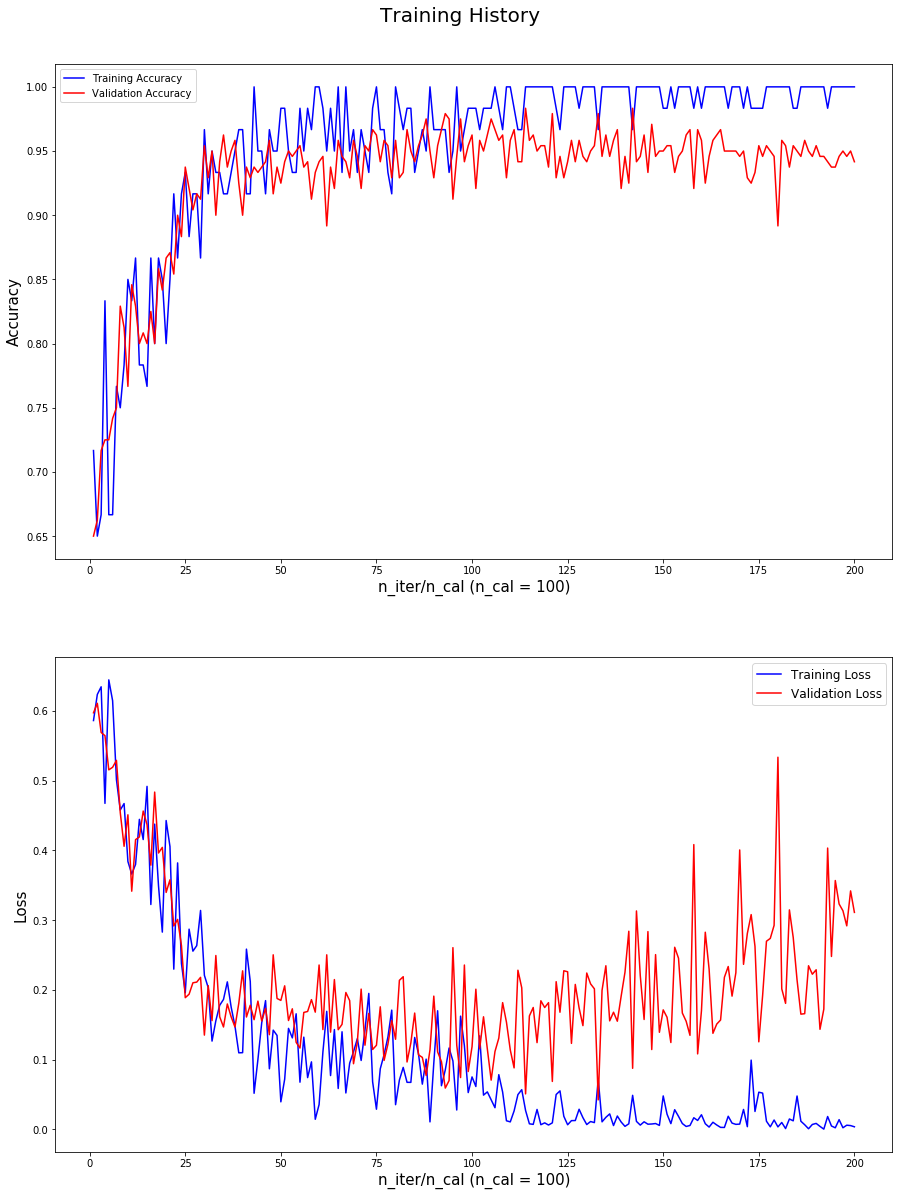

In [689]:
n_iter = 0
t_batch = 30
v_batch = 120
cal_interval = 100
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = t_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = v_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

## equal batch-size by class and eqaul batch-size by lesion 

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0107 01:07:06.433041 140197045896960 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[1000] || 91.67 %    || 85.00 %    || 0.23068191 || 0.35807580
--------------------------------------------------------------
[2000] || 93.33 %    || 93.75 %    || 0.19732839 || 0.16244005
--------------------------------------------------------------
[3000] || 95.00 %    || 92.92 %    || 0.18068735 || 0.17144535
--------------------------------------------------------------
[4000] || 96.67 %    || 94.58 %    || 0.10349487 || 0.14617488
--------------------------------------------------------------
[5000] || 96.67 %    || 92.08 %    || 0.07182549 || 0.20403354
--------------------------------------------------------------
[6000] || 95.00 %    || 92.92 %    || 0.15908988 || 0.17236313
--------------------------------------------------------------
[7000] || 91.67 %    || 94.17 %    || 0.27038080 || 0.17306384
--------------------------------------------------------------
[8000] || 98.33 %    || 94.58 %    || 0.05293626 || 0.13770482
-------------------------------------------------------

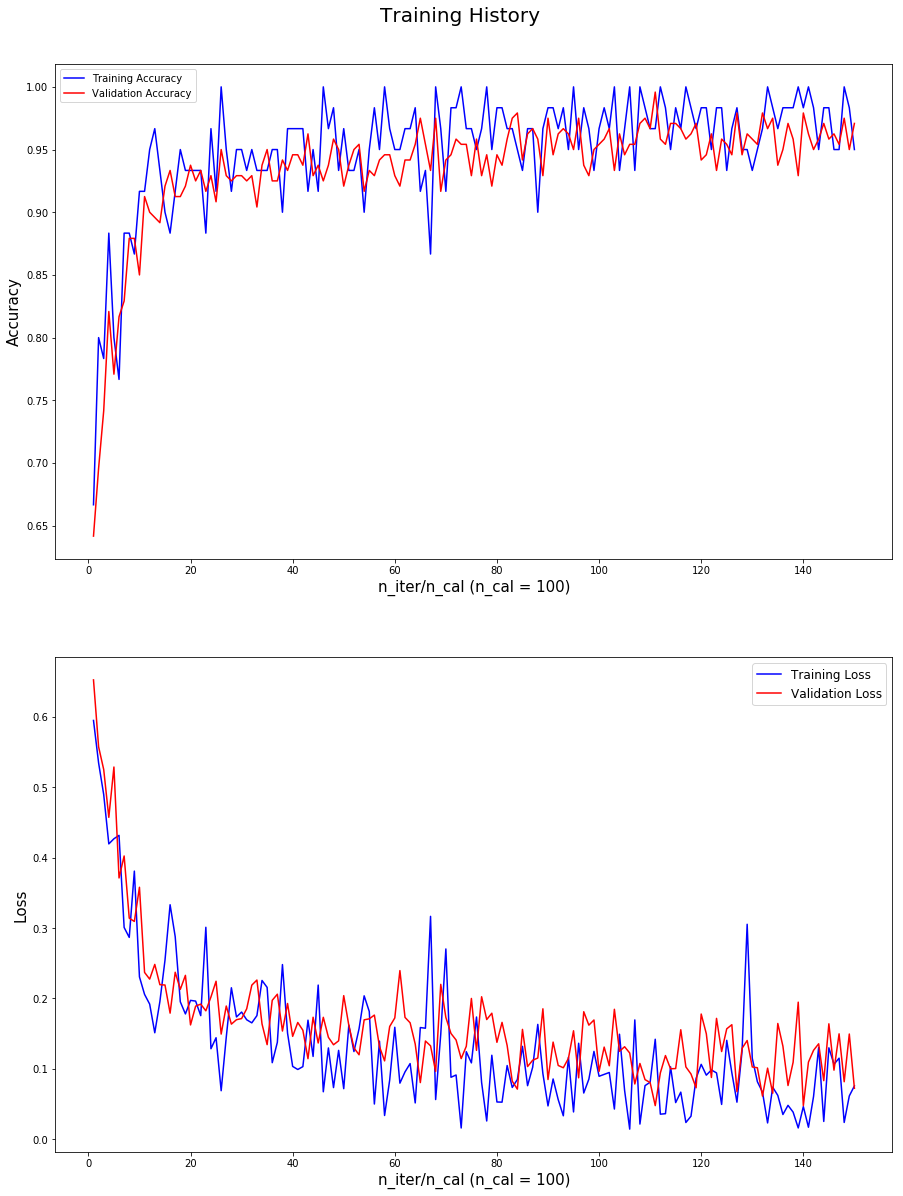

In [9]:
lr = 1e-4
n_iter = 0
t_batch = 30
v_batch = 120
cal_interval = 100
prt_interval = 1000
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(t_batch/6))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(t_batch/6))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(t_batch/6))
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(t_batch/6))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(t_batch/6))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(t_batch/6))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))

        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(v_batch/6))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(v_batch/6))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(v_batch/6))
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(v_batch/6))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(v_batch/6))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(v_batch/6))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 15000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[16000] || 100.00 %    || 96.25 %    || 0.02203928 || 0.10379470
--------------------------------------------------------------
[17000] || 100.00 %    || 98.33 %    || 0.00824353 || 0.06218592
--------------------------------------------------------------
[18000] || 98.33 %    || 93.33 %    || 0.08410241 || 0.24398020
--------------------------------------------------------------
[19000] || 98.33 %    || 96.67 %    || 0.02551497 || 0.11523689
--------------------------------------------------------------
[20000] || 98.33 %    || 97.50 %    || 0.03929265 || 0.08891280
--------------------------------------------------------------
Training Time : 52 Min.
Early Stopping : False
Iteration : 20000



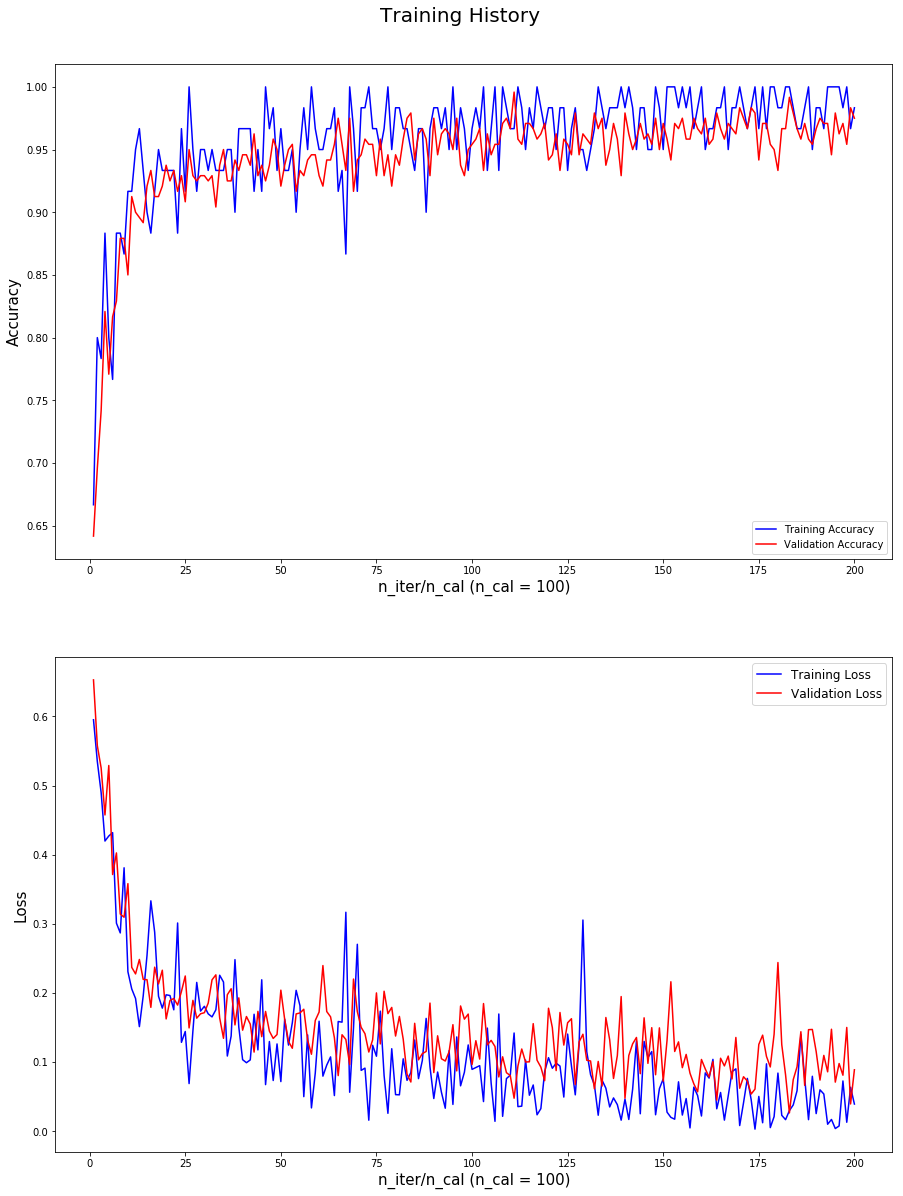

In [10]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(t_batch/6))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(t_batch/6))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(t_batch/6))
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(t_batch/6))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(t_batch/6))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(t_batch/6))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))

        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(v_batch/6))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(v_batch/6))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(v_batch/6))
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(v_batch/6))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(v_batch/6))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(v_batch/6))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 20000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[21000] || 100.00 %    || 98.75 %    || 0.01006107 || 0.03115217
--------------------------------------------------------------
[22000] || 100.00 %    || 96.25 %    || 0.00537101 || 0.18914038
--------------------------------------------------------------
[23000] || 100.00 %    || 95.83 %    || 0.01153431 || 0.11564136
--------------------------------------------------------------
[24000] || 100.00 %    || 95.42 %    || 0.00409436 || 0.15337364
--------------------------------------------------------------
[25000] || 100.00 %    || 95.83 %    || 0.00390469 || 0.15857925
--------------------------------------------------------------
[26000] || 100.00 %    || 96.67 %    || 0.00594488 || 0.11449434
--------------------------------------------------------------
[27000] || 100.00 %    || 97.50 %    || 0.00653582 || 0.03755256
--------------------------------------------------------------
[28000] || 98.33 %    || 96.25 %    || 0.

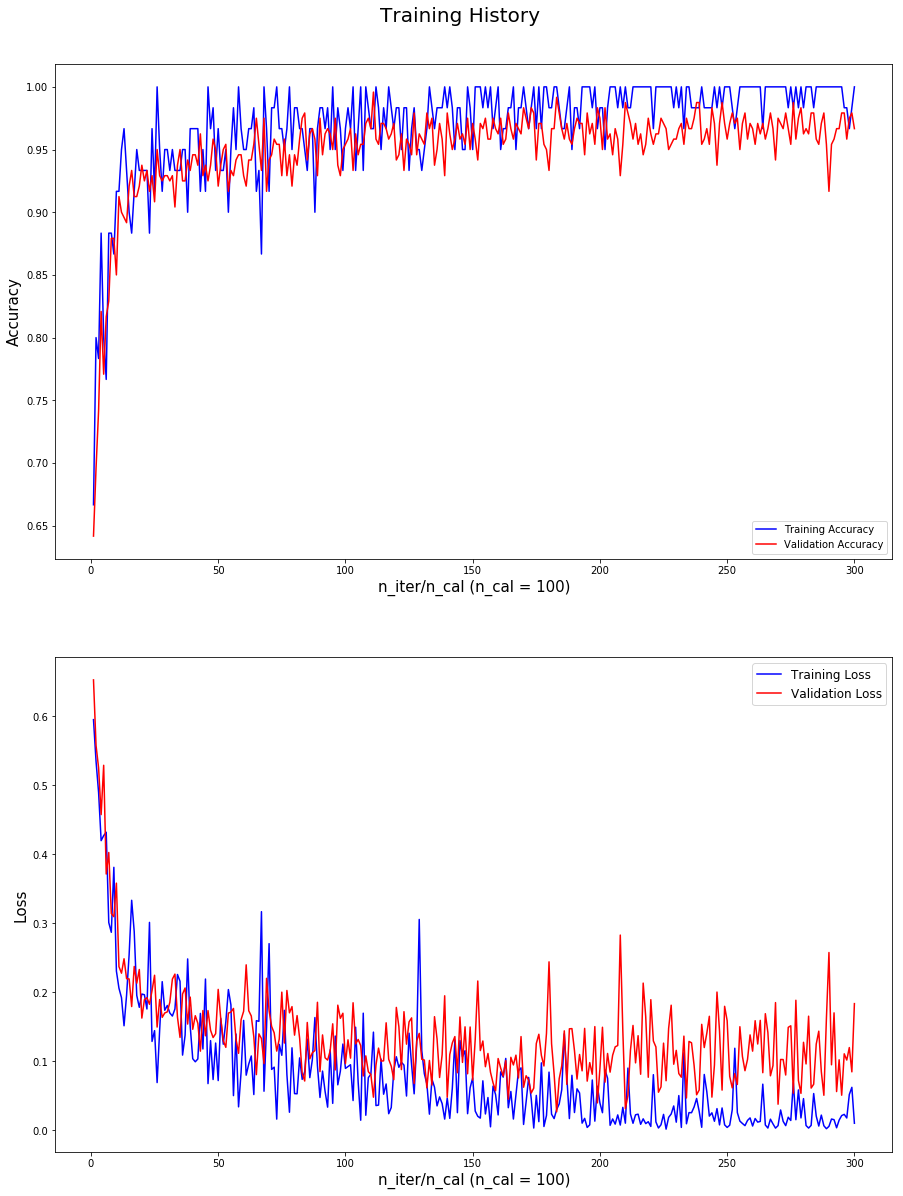

In [11]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(t_batch/6))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(t_batch/6))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(t_batch/6))
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(t_batch/6))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(t_batch/6))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(t_batch/6))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))

        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(v_batch/6))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(v_batch/6))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(v_batch/6))
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(v_batch/6))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(v_batch/6))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(v_batch/6))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 30000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[31000] || 100.00 %    || 95.83 %    || 0.01159510 || 0.13841793
--------------------------------------------------------------
[32000] || 100.00 %    || 95.83 %    || 0.01244536 || 0.14009796
--------------------------------------------------------------
[33000] || 100.00 %    || 97.50 %    || 0.00246249 || 0.13893609
--------------------------------------------------------------
[34000] || 100.00 %    || 94.17 %    || 0.00736037 || 0.20281169
--------------------------------------------------------------
[35000] || 100.00 %    || 98.33 %    || 0.00903896 || 0.04904207
--------------------------------------------------------------
[36000] || 100.00 %    || 93.75 %    || 0.00965683 || 0.34054002
--------------------------------------------------------------
[37000] || 100.00 %    || 97.50 %    || 0.00656501 || 0.14009841
--------------------------------------------------------------
[38000] || 98.33 %    || 95.83 %    || 0.

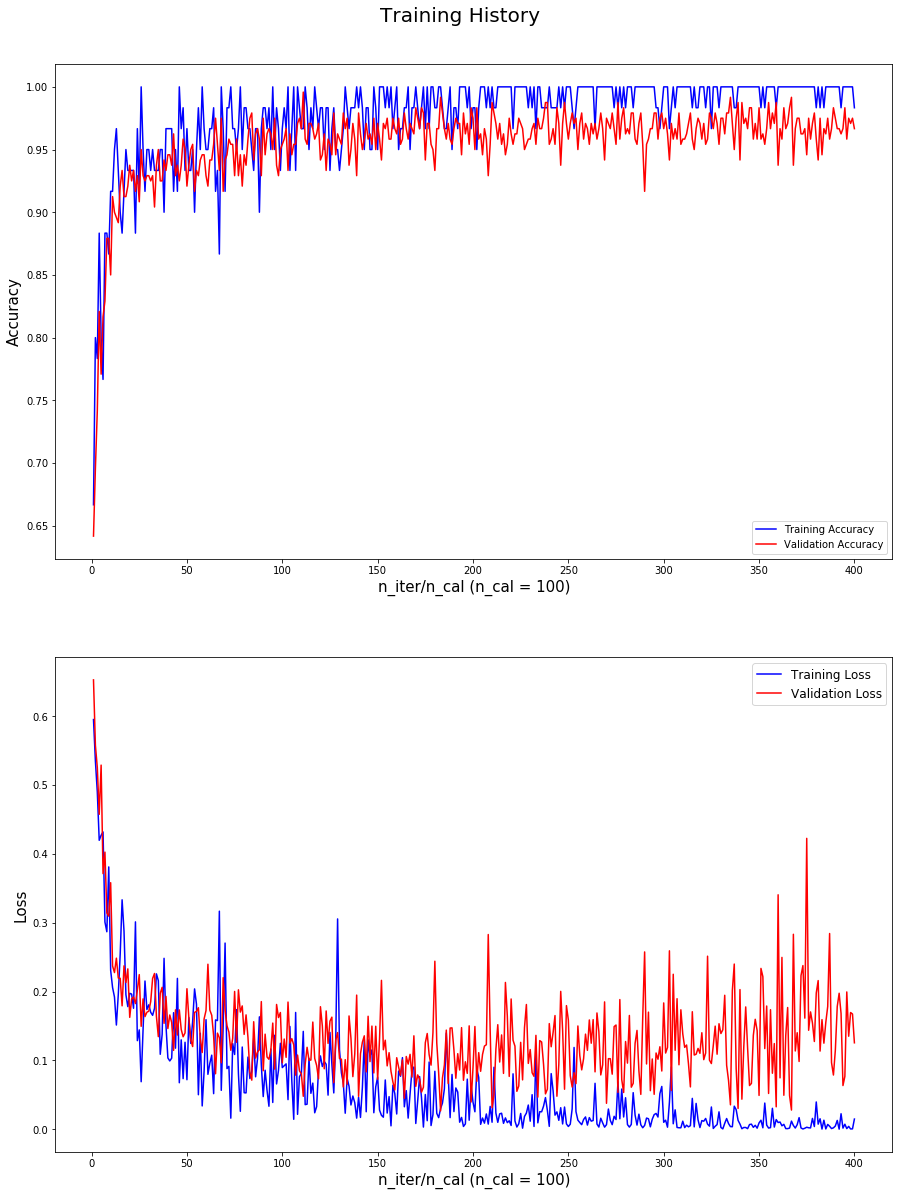

In [12]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = t_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(t_batch/6))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(t_batch/6))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(t_batch/6))
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(t_batch/6))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(t_batch/6))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(t_batch/6))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))

        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = v_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(v_batch/6))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(v_batch/6))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(v_batch/6))
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(v_batch/6))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(v_batch/6))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(v_batch/6))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

In [18]:
y = np.asarray(accr_train).reshape(-1, 1)

In [73]:
len(y)

400

In [74]:
x = np.arange(len(y)).reshape(-1, 1)

In [20]:
x.shape

(400, 1)

In [55]:
X = np.hstack([x**i for i in range(2)])

In [77]:
u = np.linspace(0, len(x), d)

In [78]:
u

array([  0., 100., 200., 300., 400.])

In [80]:
d = 5
u = np.linspace(0, len(x), d)

X = np.hstack([np.exp(x - u[k])**2/(2*(sigma**2)) for k in range(d)])

/home/project/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
/home/project/.local/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in true_divide
  after removing the cwd from sys.path.


In [81]:
X

array([[1.25000000e+001, 1.72987066e-086, 2.39396200e-173,
        3.31299569e-260, 0.00000000e+000],
       [9.23632012e+001, 1.27821113e-085, 1.76891195e-172,
        2.44799110e-259, 0.00000000e+000],
       [6.82476875e+002, 9.44477377e-085, 1.30705896e-171,
        1.80883436e-258, 0.00000000e+000],
       ...,
       [            inf, 1.16904779e+259, 1.61784117e+172,
        2.23892478e+085, 3.09844022e-002],
       [            inf, 8.63815967e+259, 1.19543192e+173,
        1.65435408e+086, 2.28945486e-001],
       [            inf, 6.38278464e+260, 8.83311349e+173,
        1.22241151e+087, 1.69169104e+000]])

In [68]:
u

array([-4.5 , -2.25,  0.  ,  2.25,  4.5 ])

In [72]:
X.shape

(5,)

In [70]:
X

matrix([[1.01288549e+05, 1.12521414e+03, 1.25000000e+01, 1.38862457e-01,
         1.54262255e-03],
        [7.48426771e+05, 8.31427041e+03, 9.23632012e+01, 1.02606248e+00,
         1.13985246e-02],
        [5.53016740e+06, 6.14346105e+04, 6.82476875e+02, 7.58163325e+00,
         8.42243375e-02],
        ...,
        [           inf,            inf,            inf,            inf,
                    inf],
        [           inf,            inf,            inf,            inf,
                    inf],
        [           inf,            inf,            inf,            inf,
                    inf]])

In [65]:
X = np.asmatrix(X)
y = np.asmatrix(y)

In [66]:
theta = (X.T*X).I*X.T*y

ValueError: array must not contain infs or NaNs

In [85]:
import pandas as pd

In [92]:
df = pd.DataFrame(columns= ['iter', 'accr_train'])

for i in range(400):
    df.loc[i] = [x[i], y[i]]

In [122]:
x = [100*i for i in range(1, len(y)+1)]

In [123]:
data = {'iter' : x, 'valid accuracy' : accr_valid, 'train accuracy' : accr_train, 'valid loss' : loss_valid, 'train loss' : loss_train}

In [124]:
df = pd.DataFrame(data = data, columns= ['iter', 'train accuracy', 'valid accuracy', 'train loss', 'valid loss'])

In [125]:
df.index[:]

RangeIndex(start=0, stop=400, step=1)

In [126]:
df

,iter,train accuracy,valid accuracy,train loss,valid loss
0,100,0.666667,0.641667,0.595106,0.652768
1,200,0.800000,0.695833,0.534759,0.557643
2,300,0.783333,0.741667,0.489752,0.525384
3,400,0.883333,0.820833,0.419692,0.457409
4,500,0.800000,0.770833,0.426984,0.528939
5,600,0.766667,0.816667,0.431828,0.371285
6,700,0.883333,0.829167,0.300938,0.402523
7,800,0.883333,0.879167,0.286806,0.314129
8,900,0.866667,0.879167,0.381010,0.309489
9,1000,0.916667,0.850000,0.230682,0.358076


In [67]:
theta

matrix([[9.38124480e-01],
        [1.94655904e-04]])

In [59]:
y_hat = X*theta

In [127]:
accr_train

[0.6666666666666666,
 0.8,
 0.7833333333333333,
 0.8833333333333333,
 0.8,
 0.7666666666666667,
 0.8833333333333333,
 0.8833333333333333,
 0.8666666666666667,
 0.9166666666666666,
 0.9166666666666666,
 0.95,
 0.9666666666666667,
 0.9333333333333333,
 0.9,
 0.8833333333333333,
 0.9166666666666666,
 0.95,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.8833333333333333,
 0.9666666666666667,
 0.9166666666666666,
 1.0,
 0.95,
 0.9166666666666666,
 0.95,
 0.95,
 0.9333333333333333,
 0.95,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.95,
 0.95,
 0.9,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9166666666666666,
 0.95,
 0.9166666666666666,
 1.0,
 0.9666666666666667,
 0.9833333333333333,
 0.9333333333333333,
 0.9666666666666667,
 0.9333333333333333,
 0.9333333333333333,
 0.95,
 0.9,
 0.95,
 0.9833333333333333,
 0.95,
 1.0,
 0.9666666666666667,
 0.95,
 0.95,
 0.9666666666666667,
 0.96666666666

In [156]:
x

array([[-4.5       ],
       [-4.47744361],
       [-4.45488722],
       [-4.43233083],
       [-4.40977444],
       [-4.38721805],
       [-4.36466165],
       [-4.34210526],
       [-4.31954887],
       [-4.29699248],
       [-4.27443609],
       [-4.2518797 ],
       [-4.22932331],
       [-4.20676692],
       [-4.18421053],
       [-4.16165414],
       [-4.13909774],
       [-4.11654135],
       [-4.09398496],
       [-4.07142857],
       [-4.04887218],
       [-4.02631579],
       [-4.0037594 ],
       [-3.98120301],
       [-3.95864662],
       [-3.93609023],
       [-3.91353383],
       [-3.89097744],
       [-3.86842105],
       [-3.84586466],
       [-3.82330827],
       [-3.80075188],
       [-3.77819549],
       [-3.7556391 ],
       [-3.73308271],
       [-3.71052632],
       [-3.68796992],
       [-3.66541353],
       [-3.64285714],
       [-3.62030075],
       [-3.59774436],
       [-3.57518797],
       [-3.55263158],
       [-3.53007519],
       [-3.5075188 ],
       [-3

In [133]:
x.shape

(400, 1)

In [206]:
np.asarray(accr_train).reshape(-1, 1)

array([[0.66666667],
       [0.8       ],
       [0.78333333],
       [0.88333333],
       [0.8       ],
       [0.76666667],
       [0.88333333],
       [0.88333333],
       [0.86666667],
       [0.91666667],
       [0.91666667],
       [0.95      ],
       [0.96666667],
       [0.93333333],
       [0.9       ],
       [0.88333333],
       [0.91666667],
       [0.95      ],
       [0.93333333],
       [0.93333333],
       [0.93333333],
       [0.93333333],
       [0.88333333],
       [0.96666667],
       [0.91666667],
       [1.        ],
       [0.95      ],
       [0.91666667],
       [0.95      ],
       [0.95      ],
       [0.93333333],
       [0.95      ],
       [0.93333333],
       [0.93333333],
       [0.93333333],
       [0.95      ],
       [0.95      ],
       [0.9       ],
       [0.96666667],
       [0.96666667],
       [0.96666667],
       [0.96666667],
       [0.91666667],
       [0.95      ],
       [0.91666667],
       [1.        ],
       [0.96666667],
       [0.983

In [650]:
y = np.asarray(accr_train).reshape(-1, 1)
x = np.linspace(-4.5, 4.5, len(y)).reshape(-1, 1)

d = 20
u = np.linspace(-4.5, 4.5, d).reshape(-1, 1)
sigma = 1
X = np.hstack([np.exp(-(x - u[i])**2/(2*(sigma**2))) for i in range(d)])

X = np.asmatrix(X)
y = np.asmatrix(y)

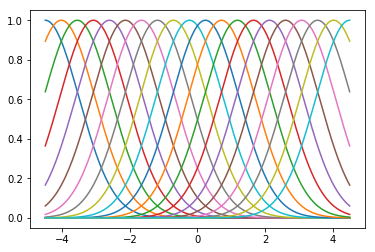

In [651]:
for i in range(d):
    plt.plot(x, X[:, i])

In [652]:
theta = (X.T*X).I*X.T*y

In [653]:
lam = 0.5
I = np.eye(d)

theta2 = (X.T*X+lam*I).I*X.T*y

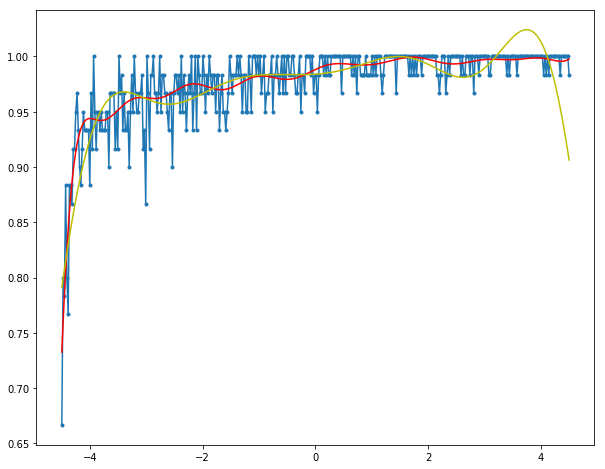

In [654]:
xp = np.linspace(-4.5, 4.5, 40000).reshape(-1, 1)

Xp = np.hstack([np.exp(-(xp - u[i])**2/(2*(sigma**2))) for i in range(d)])
yp = Xp*theta
yp2 = Xp*theta2

plt.figure(figsize = (10, 8))
plt.plot(x, y, '.-')
# plt.plot(x, y_)
plt.plot(xp, yp, 'r-')
plt.plot(xp, yp2, 'y-')
plt.show()

In [491]:
x = np.linspace(0, 1, len(y)).reshape(-1, 1)

In [543]:
deg = 9
X = np.hstack([x**i for i in range(deg)])

y = np.asmatrix(y)
X = np.asmatrix(X)

lam = 0
theta = (X.T*X-lam*np.eye(deg)).I*X.T*y

In [544]:
theta

matrix([[ 7.84840191e-01],
        [ 5.03193868e+00],
        [-5.63505799e+01],
        [ 3.17673845e+02],
        [-9.95392470e+02],
        [ 1.81661761e+03],
        [-1.91973500e+03],
        [ 1.08822652e+03],
        [-2.55871061e+02]])

In [545]:
# xp = np.array([i for i in range(1, 100*(len(y))+1)]).reshape(-1, 1)
xp = np.linspace(0, 1, 100*len(y)).reshape(-1, 1)
Xp = np.hstack([xp**i for i in range(deg)])
yp = Xp*theta

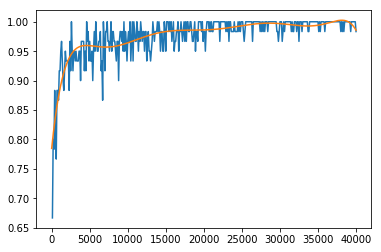

In [548]:
x = np.array([100*i for i in range(1, len(y)+1)]).reshape(-1, 1)
xp = np.array([i for i in range(1, 100*(len(y))+1)]).reshape(-1, 1)

plt.plot(x, y)
plt.plot(xp, yp, alpha = 5)

In [285]:
from sklearn.ensemble import RandomForestRegressor

In [661]:
x = [100*i for i in range(1, len(y)+1)]

In [662]:
x = np.reshape(x, (-1, 1))

In [663]:
x.shape, y.shape

((400, 1), (400, 1))

In [664]:
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [679]:
rf_reg = RandomForestRegressor(n_estimators=100, criterion = 'mae', verbose=True)
rf_reg.fit(x, np.ravel(y))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=True, warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished


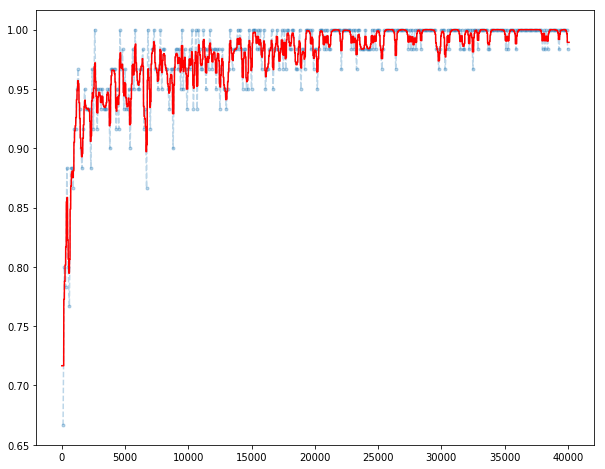

In [680]:
xp = np.array([i for i in range(1, 100*(len(y)+1)+1)]).reshape(-1, 1)

yp = rf_reg.predict(xp)

plt.figure(figsize = (10, 8))
plt.plot(x, y, '.--', alpha = 0.3)
# plt.plot(x, y_)
plt.plot(xp, yp, 'r-')
plt.show()

In [317]:
from sklearn.neural_network import MLPRegressor

In [318]:
MLPRegressor()

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [388]:
mlp_reg = MLPRegressor(activation='logistic', hidden_layer_sizes=(1000,), n_iter_no_change=200, verbose=True, learning_rate_init = 0.0001)
mlp_reg.fit(x, np.ravel(y))

Iteration 1, loss = 0.38809766
Iteration 2, loss = 0.27070544
Iteration 3, loss = 0.17809396
Iteration 4, loss = 0.10170376
Iteration 5, loss = 0.04224344
Iteration 6, loss = 0.00771188
Iteration 7, loss = 0.00187745
Iteration 8, loss = 0.00586472
Iteration 9, loss = 0.00925767
Iteration 10, loss = 0.01263304
Iteration 11, loss = 0.01465652
Iteration 12, loss = 0.01501620
Iteration 13, loss = 0.01384100
Iteration 14, loss = 0.01152410
Iteration 15, loss = 0.00878858
Iteration 16, loss = 0.00613003
Iteration 17, loss = 0.00377490
Iteration 18, loss = 0.00200480
Iteration 19, loss = 0.00089273
Iteration 20, loss = 0.00038126
Iteration 21, loss = 0.00029049
Iteration 22, loss = 0.00049640
Iteration 23, loss = 0.00079295
Iteration 24, loss = 0.00105183
Iteration 25, loss = 0.00119367
Iteration 26, loss = 0.00119419
Iteration 27, loss = 0.00107372
Iteration 28, loss = 0.00088591
Iteration 29, loss = 0.00067026
Iteration 30, loss = 0.00047918
Iteration 31, loss = 0.00034777
Iteration 32, los

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(1000,), learning_rate='constant',
             learning_rate_init=0.0001, max_iter=200, momentum=0.9,
             n_iter_no_change=200, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

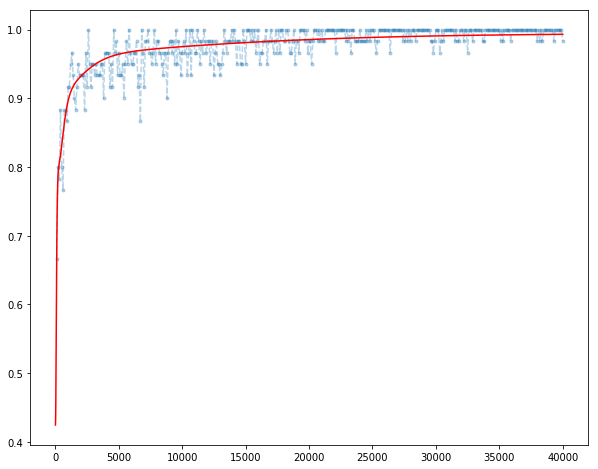

In [390]:
xp = np.array([i for i in range(1, 100*(len(y))+1)]).reshape(-1, 1)
yp = mlp_reg.predict(xp)

plt.figure(figsize = (10, 8))
plt.plot(x, y, '.--', alpha = 0.3)
# plt.plot(x, y_)
plt.plot(xp, yp, 'r-')
plt.show()

In [364]:
a_t = np.asarray(accr_train).reshape(-1, 1)
a_v = np.asarray(accr_valid).reshape(-1, 1)
l_t = np.asarray(loss_train).reshape(-1, 1)
l_v = np.asarray(loss_valid).reshape(-1, 1)
x = np.array([100*i for i in range(1, len(y)+1)]).reshape(-1, 1)

In [396]:
mlp_a_t = MLPRegressor(activation='logistic', n_iter_no_change=200, verbose=False, learning_rate_init = 0.0001)
mlp_a_t.fit(x, np.ravel(a_t))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.0001, max_iter=200, momentum=0.9,
             n_iter_no_change=200, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [397]:
mlp_a_v = MLPRegressor(activation='logistic', n_iter_no_change=200, verbose=False, learning_rate_init = 0.0001)
mlp_a_v.fit(x, np.ravel(a_v))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.0001, max_iter=200, momentum=0.9,
             n_iter_no_change=200, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [398]:
mlp_l_t = MLPRegressor(activation='logistic', n_iter_no_change=200, verbose=False, learning_rate_init = 0.0001)
mlp_l_t.fit(x, np.ravel(l_t))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.0001, max_iter=200, momentum=0.9,
             n_iter_no_change=200, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [401]:
mlp_l_v = MLPRegressor(activation='logistic', n_iter_no_change=200, verbose=False, learning_rate_init = 0.0001)
mlp_l_v.fit(x, np.ravel(l_v))

/usr/local/lib/python3.5/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.0001, max_iter=200, momentum=0.9,
             n_iter_no_change=200, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

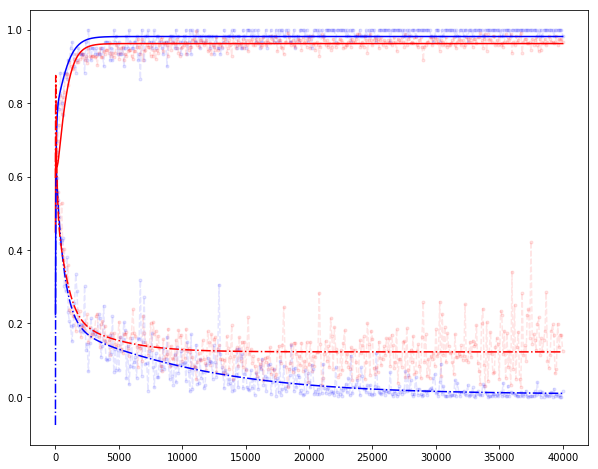

In [402]:
xp = np.array([i for i in range(1, 100*(len(y))+1)]).reshape(-1, 1)

plt.figure(figsize = (10, 8))
plt.plot(x, a_t, 'b.--', alpha = 0.1)
plt.plot(x, a_v, 'r.--', alpha = 0.1)
plt.plot(x, l_t, 'b.--', alpha = 0.1)
plt.plot(x, l_v, 'r.--', alpha = 0.1)
plt.plot(xp, mlp_a_t.predict(xp), 'b-')
plt.plot(xp, mlp_a_v.predict(xp), 'r-')
plt.plot(xp, mlp_l_t.predict(xp), 'b-.')
plt.plot(xp, mlp_l_v.predict(xp), 'r-.')
plt.show()

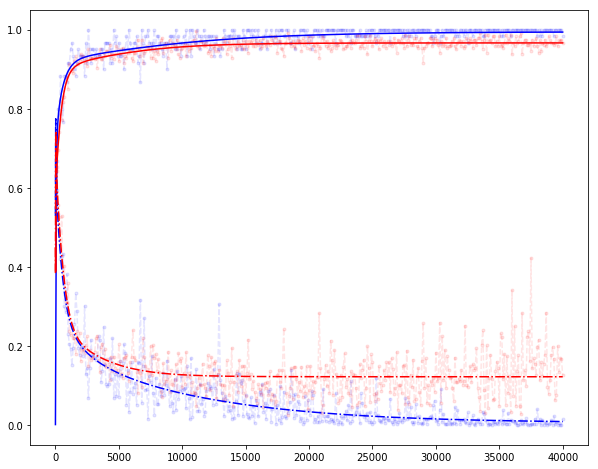

In [387]:
xp = np.array([i for i in range(1, 100*(len(y))+1)]).reshape(-1, 1)

plt.figure(figsize = (10, 8))
plt.plot(x, a_t, 'b.--', alpha = 0.1)
plt.plot(x, a_v, 'r.--', alpha = 0.1)
plt.plot(x, l_t, 'b.--', alpha = 0.1)
plt.plot(x, l_v, 'r.--', alpha = 0.1)
plt.plot(xp, mlp_a_t.predict(xp), 'b-')
plt.plot(xp, mlp_a_v.predict(xp), 'r-')
plt.plot(xp, mlp_l_t.predict(xp), 'b-.')
plt.plot(xp, mlp_l_v.predict(xp), 'r-.')
plt.show()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0106 02:22:47.782932 140360842434304 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 70.67 %    || 74.67 %    || 0.60890853 || 0.62070334
--------------------------------------------------------------
[*200] || 69.33 %    || 69.33 %    || 0.54498488 || 0.53775692
--------------------------------------------------------------
[*300] || 78.67 %    || 77.33 %    || 0.46472514 || 0.53353864
--------------------------------------------------------------
[*400] || 72.00 %    || 81.33 %    || 0.48818371 || 0.47755072
--------------------------------------------------------------
[*500] || 80.00 %    || 77.33 %    || 0.45958608 || 0.43791258
--------------------------------------------------------------
[*600] || 74.67 %    || 74.67 %    || 0.51089895 || 0.52543902
--------------------------------------------------------------
[*700] || 82.67 %    || 81.33 %    || 0.40845391 || 0.41642657
--------------------------------------------------------------
[*800] || 81.33 %    || 76.00 %    || 0.43701631 || 0.46641755
-------------------------------------------------------

[6600] || 93.33 %    || 94.67 %    || 0.19319944 || 0.08539890
--------------------------------------------------------------
[6700] || 98.67 %    || 100.00 %    || 0.04631531 || 0.02801958
--------------------------------------------------------------
[6800] || 93.33 %    || 93.33 %    || 0.13482741 || 0.18654174
--------------------------------------------------------------
[6900] || 97.33 %    || 96.00 %    || 0.13834716 || 0.11920198
--------------------------------------------------------------
[7000] || 97.33 %    || 96.00 %    || 0.07746280 || 0.13656586
--------------------------------------------------------------
[7100] || 100.00 %    || 98.67 %    || 0.01892085 || 0.06775993
--------------------------------------------------------------
[7200] || 94.67 %    || 97.33 %    || 0.12029308 || 0.06118260
--------------------------------------------------------------
[7300] || 100.00 %    || 96.00 %    || 0.01475160 || 0.11627924
----------------------------------------------------

[13100] || 100.00 %    || 96.00 %    || 0.01131297 || 0.17159340
--------------------------------------------------------------
[13200] || 98.67 %    || 97.33 %    || 0.05226332 || 0.05194430
--------------------------------------------------------------
[13300] || 100.00 %    || 98.67 %    || 0.01700412 || 0.07370602
--------------------------------------------------------------
[13400] || 97.33 %    || 92.00 %    || 0.02579269 || 0.23449282
--------------------------------------------------------------
[13500] || 98.67 %    || 98.67 %    || 0.03042213 || 0.03833836
--------------------------------------------------------------
[13600] || 100.00 %    || 94.67 %    || 0.01708738 || 0.17412080
--------------------------------------------------------------
[13700] || 98.67 %    || 94.67 %    || 0.03200340 || 0.08037020
--------------------------------------------------------------
[13800] || 100.00 %    || 94.67 %    || 0.01358941 || 0.14913182
-------------------------------------------

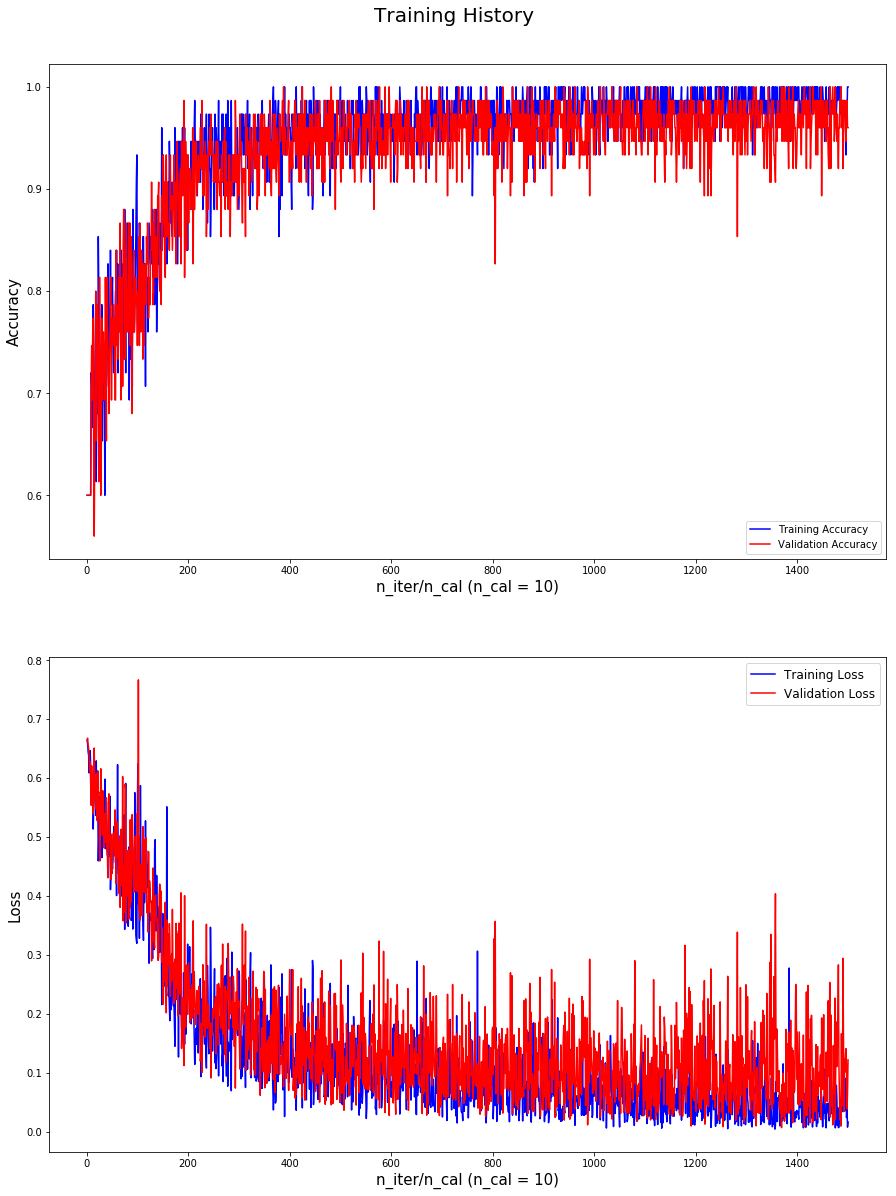

In [7]:
lr = 1e-4
n_iter = 0
n_batch = 30
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    redspot_train_x, redspot_train_y = load_random_minibatch(redspot_train_path, cls = 1, batch_size = int(n_batch/3))
    angio_train_x, angio_train_y = load_random_minibatch(angio_train_path, cls = 1, batch_size = int(n_batch/3))
    active_train_x, active_train_y = load_random_minibatch(active_train_path, cls = 1, batch_size = int(n_batch/3))
    ero_train_x, ero_train_y  = load_random_minibatch(ero_train_path, cls = 1, batch_size = int(n_batch/6))
    ulcer_train_x, ulcer_train_y = load_random_minibatch(ulcer_train_path, cls = 1, batch_size = int(n_batch/6))
    str_train_x, str_train_y = load_random_minibatch(str_train_path, cls = 1, batch_size = int(n_batch/6))
    train_x = np.vstack([neg_train_x, redspot_train_x, angio_train_x, active_train_x, ero_train_x, ulcer_train_x, str_train_x])
    train_y = np.vstack([neg_train_y, redspot_train_y, angio_train_y, active_train_y, ero_train_y, ulcer_train_y, str_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: lr})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))

        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        redspot_valid_x, redspot_valid_y = load_random_minibatch(redspot_valid_path, cls = 1, batch_size = int(n_batch/3))
        angio_valid_x, angio_valid_y = load_random_minibatch(angio_valid_path, cls = 1, batch_size = int(n_batch/3))
        active_valid_x, active_valid_y = load_random_minibatch(active_valid_path, cls = 1, batch_size = int(n_batch/3))
        ero_valid_x, ero_valid_y  = load_random_minibatch(ero_valid_path, cls = 1, batch_size = int(n_batch/6))
        ulcer_valid_x, ulcer_valid_y = load_random_minibatch(ulcer_valid_path, cls = 1, batch_size = int(n_batch/6))
        str_valid_x, str_valid_y = load_random_minibatch(str_valid_path, cls = 1, batch_size = int(n_batch/6))
        valid_x = np.vstack([neg_valid_x, redspot_valid_x, angio_valid_x, active_valid_x, ero_valid_x, ulcer_valid_x, str_valid_x])
        valid_y = np.vstack([neg_valid_y, redspot_valid_y, angio_valid_y, active_valid_y, ero_valid_y, ulcer_valid_y, str_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'B_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 15000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    lr *= 0.99999
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()